# Topic Modeling with Latent Dirichlet Allocation

## External Resources

* [Youtube Video by Luis Serrano](https://www.youtube.com/watch?v=T05t-SqKArY)
* [Illustrated Mechanism by Arun K Sharma](https://www.mygreatlearning.com/blog/understanding-latent-dirichlet-allocation/)
* [Blog Post by Thushan Ganegedara](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)
* [Blog Post by Ria Kulshrestha](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)
* [Blog Post by Shashank Kapadia about Evaluation of LDA](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

## Problem Statement

Following the introduction of SVD:
* Concept of a document made of topics = a Bag of Words made of topics
* Concept of a topic made of words

We want to solve for the limitations of SVD:
* Interpretability of negative weights
* Cross-Document comparison of topic importance between un-scaled vectors

# Example: Health in Vogue Magazine


Let's have a look at [this study by Peter Leonard](http://library.ifla.org/930/1/119-leonard-en.pdf) about the Vogue dataset.

[Vogue Magazine](https://en.wikipedia.org/wiki/Vogue_(magazine) is a women's fashion and lifestyle magazine, launched in 1916:
* Over 100,000 articles
* More than 400,000 pages

We are looking at answering 2 questions:
* What is the importance of Health in Vogue across time? What proportion of articles deal with Health in publications?
* How does Vogue deal with Health?



---



This graph shows the percentage of articles that dedicate significant room to discuss health-related topics, across time and annotated for Editor-in-Chief:

![image](https://i.ibb.co/1mf9YKq/Screenshot-from-2020-12-11-16-53-42.png)




---

This cloud of words shows which terms are mainly used to talk about health:

![image](https://i.ibb.co/ZgXqSDQ/Screenshot-from-2020-12-11-17-04-46.png)



---

As an addition, a TOP-7 articles that talk the most about Health. The percentage indicates how much of the article is dedicated to Health.

* `99%` “Q&A: The Pill” 1 Dec. 1987: 361
* `98%` Jane Ogle. “Facts on Fat: Obesity — a Heavy Health-risk Factor” 1 Aug. 1979: 249
* `96%` Melva Weber. “Inner Info: Contraception” 1 Aug. 1978: 210
* `95%` Charles Kuntzleman. “What Is the Best Way That You Can Shape Up for Active Sports?” 1 Aug. 1979: 82
* `95%` Jane Ogle. “Why Crash Diets Don't Work” 1 Aug. 1979: 248
* `91%` Melva Weber. “Latest in the IUD Dust-Up...” 1 Mar. 1975: 88
* `89%` Ellen Switzer. “Your Blood Pressure” 1 May. 1973: 152



**How can you do that, without reading and annotating each and every article ?**
Answer: Topic Modeling, with Latent Dirichlet Allocation

## Intuition

LDA is a **generative** model
* Each **Topic** is a probability distribution over a collection of words
   * Each word has a probability
   * The sum of all probabilities is equal to $1$
* Each **Document** (each BoW) is a sample of a random process, it is generated by a probability distribution over a list of topics
   * Each document is a weighted sum of topics
   * The sum of all weights is equal to $1$

The generative model runs like this:
* Given a document, the distribution of topics is a sample from a Dirichlet distribution
   * Each sample is a vector $\textrm{v}$ of dimension $K$ the number of topics
   * $\textrm{v} = (\textrm{v}_1, \textrm{v}_2, ..., \textrm{v}_K)$
   * $\textrm{v}_i \geq 0$
   * $\sum_{i=1}^K \textrm{v}_i = 1$
* The words of the document come from a random draw from the topics's word distribution
   * As different weights have been assigned to different topics, some topics will generate more words than others
   * As words in a topic do not all have the same probability, it is more likely to see some of them than the others

With the help of Machine Learning, we discover the parameters of these distributions from the corpus of text at disposal, and can represent each document as a vector of dimension $K$.

We observe the words with highest probability of each topic and label the topics manually for our understanding.


## Examples

We have 2 topics: `Sports` and `Business`.
* `Sports`: `football: 0.4`, `ronaldo: 0.2`, `goal: 0.2`, `worldcup: 0.2`
* `Business`: `revenue: 0.6`, `tax: 0.3`, `benefit: 0.1`

A document which is split:
* `Sports: 0.8` 
* `Business: 0.2`

We build the bag of words the following way:
* 80% of the time, we draw a word from the `Sports` distribution. 
* 20% of the time, a word from `Business`

For a 5-word bag of words, we obtain:
* 4 words from `Sports`: `football: 1`, `ronaldo: 1`, `goal: 2`
* 1 word from `Business`: `revenue: 1`

This bag of words is valid for a document like `Football star Ronaldo's revenue grows as he scores goal after goal`. 

(admitting `grow` and `star` would be stop-words, but it's a toy example, we can allow this).


## Explain the Vogue Research

* This was a LDA modeling with $K=20$ topics
* Topic #14 was labeled as Health
* The graph shows the number of articles where the 14th coefficient of the LDA vector is higher than $0.2$, as a percentage of the total number of articles published in a year.

# Application

We will use a dataset of BBC articles, see the [BBC Page](http://mlg.ucd.ie/datasets/bbc.html)

We use gensim implementation of LDA. See [Link](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html)

In [1]:
# Activate or deactivate logging by changing False into True
# Gensim can be very verbose !!!

if True:
    import logging
    logging.basicConfig(format="%(asctime)s:%(name)s:%(levelname)s:%(message)s",
                        level=logging.INFO)

## Prepare Corpus

In [2]:
import requests

r = requests.get('http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip')

assert r.status_code == 200

with open('bbc-fulltext.zip', 'wb') as out:
    out.write(r.content)
    

In [3]:
from zipfile import ZipFile

texts = []
with ZipFile('bbc-fulltext.zip') as zf:
    txtfiles = filter(lambda x: x.endswith('.txt'), zf.namelist())
    for txtf in txtfiles:
        with zf.open(txtf, 'r') as txt:
            texts.append(txt.read().decode('utf-8', 'ignore').lower().replace('\n', ' '))

print(f'Collected {len(texts)} articles.')

Collected 2225 articles.


In [4]:
# Input from DSP project
import numpy as np

url = '/Users/dj/Documents/GitHub/inbraak_'
numbers = np.arange(1,7)
ending = '.txt'

texts = []
for i in numbers:
    p = url + str(i) + ending
    f = open(p,'r')
    text = f.read()
    texts.append(text)

In [5]:
texts[0]

'Translated(src=nl, dest=en, text=ass="linebreak1">the public prosecutor at the East Netherlands district prosecutor\'s office against\n          [suspect]\n        born on [date of birth] 1995 in [place of birth] currently detained in [detention address] counsel: mr. T. Kocabas, lawyer in Zoetermeer. indictment The suspect has been charged with: 1. Primarily he on or about August 23, 2017 in Zwolle, at least in the Netherlands, together and in association with another or others, at least alone, to carry out the crime intended by the suspect to commit the crime with the intent of misappropriation in/from a home located at [address 1], goods and/or money to be taken away, belonging wholly or partly to [victim 1], in any case to someone else or others than the suspect and /or his co-perpetrators, thereby gaining access to the scene of the crime and/or bringing the goods/money to be removed within his/her/their reach by means of forcible entry, breaking, climbing, as follows: hey committe

We will build the vocabulary as follows:
* We want 1-grams and 2-grams
* Tokenize the text with `spacy`, create 2 versions
   * One with each token
   * Another one where stopwords are removed
* Use `gensim` Phrases to generate 2-grams
   * It uses the full tokenized version of the corpus
   * It names bigrams as `after_hour`, and identifies more complex structures, such as `king_of_heart` which is a 2-gram when discounting the stopword `of` which is only a connector here
* After the 2-grams are generated, we add them to the 'tokenized and stopped' corpus
   * LDA is a generative model for the Bag of Words
   * Composition does not matter
   * What matters is that the right list of terms and counts is provided


In [6]:
import spacy

nlp = spacy.load('en_core_web_sm')

full_tokenized = list(map(
    lambda tokens: [t.text for t in tokens if len(t.text) > 1], 
    nlp.tokenizer.pipe(texts)  # [['I', 'Love', 'tea'], ['I', 'teach', 'at', 'uva']]
))

add_stops = ['said', 'mr']

def filter_tokens(x):
    return [t.text for t in x if len(t.text) > 1 and not t.is_stop and t.text not in add_stops]

stopped_tokenized = list(map(
    filter_tokens,
    nlp.tokenizer.pipe(texts) # [['I', 'Love', 'tea'], ['I', 'teach', 'at', 'uva']]
))

In [7]:
import warnings

from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Add bigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(full_tokenized, min_count=10)
for idx in range(len(full_tokenized)):
    for token in bigram[full_tokenized[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            stopped_tokenized[idx].append(token)

dictionary = Dictionary(stopped_tokenized)

# Filter out words that occur less than 10 documents, or more than 90% of the documents.
# Same effect as min_df, max_df in CountVectorizer 
dictionary.filter_extremes(no_below=5, no_above=0.9)
dictionary.compactify()

corpus = [dictionary.doc2bow(txt) for txt in stopped_tokenized]

2021-11-26 09:52:04,609:gensim.models.phrases:INFO:collecting all words and their counts
2021-11-26 09:52:04,610:gensim.models.phrases:INFO:PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-11-26 09:52:04,616:gensim.models.phrases:INFO:collected 4746 token types (unigram + bigrams) from a corpus of 7032 words and 6 sentences
2021-11-26 09:52:04,616:gensim.models.phrases:INFO:merged Phrases<4746 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
2021-11-26 09:52:04,636:gensim.utils:INFO:Phrases lifecycle event {'msg': 'built Phrases<4746 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2021-11-26T09:52:04.617558', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-11-26 09:52:04,648:gensim.corpora.dictionary:INFO:adding document #0 to Dictionary(0 unique tokens: [])
2021-11-26 09:52:04,651:gensim.corpora.dictionary:IN

In [8]:
len(dictionary)

33

In [9]:
list([(i, dictionary[i]) for i in range(20)])

[(0, 'address'),
 (1, 'at_address'),
 (2, 'belonging'),
 (3, 'break'),
 (4, 'charges'),
 (5, 'co'),
 (6, 'counsel'),
 (7, 'crime'),
 (8, 'garden'),
 (9, 'lawyer'),
 (10, 'offense'),
 (11, 'open'),
 (12, 'place'),
 (13, 'regard'),
 (14, 'regard_to'),
 (15, 'text'),
 (16, 'took'),
 (17, 'The_court'),
 (18, 'acquitted'),
 (19, 'attached')]

## LDA Model

The number of topics is a Hyperparameter of our model.

In evaluation, we will be able to see what would be a *better* choice for the number of topics.

In [10]:
K = 10

In [11]:
from gensim.models.ldamodel import LdaModel

lda = LdaModel(
    corpus=corpus, 
    id2word=dictionary,
    num_topics=K, 
    alpha='auto',
    eta='auto',
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True
)

2021-11-26 09:52:04,754:gensim.models.ldamodel:INFO:using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2021-11-26 09:52:04,756:gensim.models.ldamodel:INFO:using serial LDA version on this node
2021-11-26 09:52:04,757:gensim.models.ldamodel:INFO:running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 6 documents, updating model once every 6 documents, evaluating perplexity every 0 documents, iterating 100x with a convergence threshold of 0.001000
2021-11-26 09:52:04,758:gensim.models.ldamodel:INFO:PROGRESS: pass 0, at document #6/6
2021-11-26 09:52:04,769:gensim.models.ldamodel:INFO:optimized alpha [0.06915864, 0.064960636, 0.045330044, 0.06684501, 0.067200825, 0.06540696, 0.16662979, 0.066398636, 0.04533023, 0.06816371]
2021-11-26 09:52:04,770:gensim.models.ldamodel:INFO:topic #2 (0.045): 0.030*"court" + 0.030*"crime" + 0.030*"at_address" + 0.030*"address" + 0.030*"co" + 0.030*"The_court" + 0.030*"break" + 0.030*"n

## Annotation

### View Topics

We have a look at each topic, and the corresponding list of words.

* Each topic is a probability distribution over the vocabulary
* Each word has a probability between 0 and 1
* Words with high probabilities indicate important words for the topic
* We focus on the TOP 10 words to annotate and give a title to a topic

In [12]:
lda.print_topics()

2021-11-26 09:52:04,952:gensim.models.ldamodel:INFO:topic #0 (0.038): 0.223*"crime" + 0.186*"co" + 0.100*"open" + 0.087*"break" + 0.087*"address" + 0.075*"belonging" + 0.075*"at_address" + 0.026*"garden" + 0.014*"lawyer" + 0.014*"text"
2021-11-26 09:52:04,953:gensim.models.ldamodel:INFO:topic #1 (0.018): 0.030*"at_address" + 0.030*"address" + 0.030*"court" + 0.030*"The_court" + 0.030*"statement" + 0.030*"found" + 0.030*"regard" + 0.030*"regard_to" + 0.030*"number" + 0.030*"crime"
2021-11-26 09:52:04,953:gensim.models.ldamodel:INFO:topic #2 (0.016): 0.030*"The_court" + 0.030*"at_address" + 0.030*"break" + 0.030*"co" + 0.030*"court" + 0.030*"crime" + 0.030*"address" + 0.030*"evidence" + 0.030*"circumstances" + 0.030*"established"
2021-11-26 09:52:04,953:gensim.models.ldamodel:INFO:topic #3 (0.018): 0.031*"saw" + 0.030*"address" + 0.030*"at_address" + 0.030*"court" + 0.030*"took" + 0.030*"number" + 0.030*"The_court" + 0.030*"place" + 0.030*"judgment" + 0.030*"break"
2021-11-26 09:52:04,95

[(0,
  '0.223*"crime" + 0.186*"co" + 0.100*"open" + 0.087*"break" + 0.087*"address" + 0.075*"belonging" + 0.075*"at_address" + 0.026*"garden" + 0.014*"lawyer" + 0.014*"text"'),
 (1,
  '0.030*"at_address" + 0.030*"address" + 0.030*"court" + 0.030*"The_court" + 0.030*"statement" + 0.030*"found" + 0.030*"regard" + 0.030*"regard_to" + 0.030*"number" + 0.030*"crime"'),
 (2,
  '0.030*"The_court" + 0.030*"at_address" + 0.030*"break" + 0.030*"co" + 0.030*"court" + 0.030*"crime" + 0.030*"address" + 0.030*"evidence" + 0.030*"circumstances" + 0.030*"established"'),
 (3,
  '0.031*"saw" + 0.030*"address" + 0.030*"at_address" + 0.030*"court" + 0.030*"took" + 0.030*"number" + 0.030*"The_court" + 0.030*"place" + 0.030*"judgment" + 0.030*"break"'),
 (4,
  '0.031*"crime" + 0.031*"co" + 0.031*"belonging" + 0.030*"open" + 0.030*"address" + 0.030*"at_address" + 0.030*"break" + 0.030*"garden" + 0.030*"lawyer" + 0.030*"regard_to"'),
 (5,
  '0.030*"saw" + 0.030*"address" + 0.030*"court" + 0.030*"The_court" + 

This is one case where wordclouds come in handy.

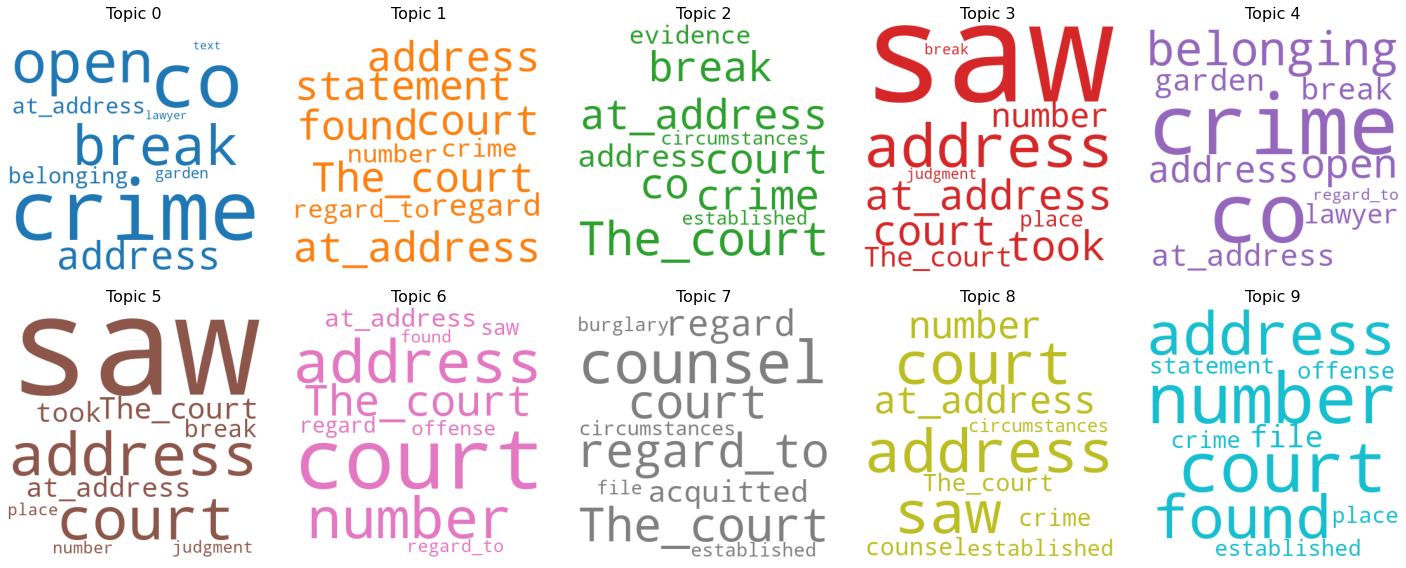

In [13]:
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

nb_columns = 5
nb_rows = math.ceil(K / nb_columns)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(background_color='white',
                  width=400,
                  height=400,
                  max_words=10,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)

fig, axes = plt.subplots(ncols=nb_columns, nrows=nb_rows, 
                         figsize=(4*nb_columns, 4*nb_rows), 
                         sharex=True, sharey=True)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
    ax.axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Label the Topics

We can label the topics
* Observing the collection of most frequent words
* It is a **Human Annotation** task
* Use world knowledge, domain knowledge, historical trends and zeitgeist
* Some subjectivity...

In [14]:
names = [
    'Rugby', 
    'Video Games',
    'Radio',
    'Internet',
    'Politics',
    'Cybersecurity',
    'Mobile Devices',
    'Movies',
    'Apple',
    'Video Technology'
]

topic_names = {i: v for i, v in enumerate(names)}

### Get Topic Distribution for Documents

We get the vectors for some documents by providing a corpus
* Either `lda.get_document_topics(doc)` which take 1 corpus's document at a time
* Or `lda[corpus]` which processes the whole corpus at once

In [15]:
by_get_document_topics = list(map(
    lda.get_document_topics,
    corpus
))

by_bracket = lda[corpus]

In [16]:
from textwrap import fill

print(fill(texts[0], width=80))

Translated(src=nl, dest=en, text=ass="linebreak1">the public prosecutor at the
East Netherlands district prosecutor's office against           [suspect]
born on [date of birth] 1995 in [place of birth] currently detained in
[detention address] counsel: mr. T. Kocabas, lawyer in Zoetermeer. indictment
The suspect has been charged with: 1. Primarily he on or about August 23, 2017
in Zwolle, at least in the Netherlands, together and in association with another
or others, at least alone, to carry out the crime intended by the suspect to
commit the crime with the intent of misappropriation in/from a home located at
[address 1], goods and/or money to be taken away, belonging wholly or partly to
[victim 1], in any case to someone else or others than the suspect and /or his
co-perpetrators, thereby gaining access to the scene of the crime and/or
bringing the goods/money to be removed within his/her/their reach by means of
forcible entry, breaking, climbing, as follows: hey committed, he, the s

* Not exactly the same structure (more info returned by `[]`)
* Some small numerical differences, but insignificant
* Return the list of TOP topics, and set to 0 all those who had a very low value

In [17]:
print(f'Using get_document_topics: {by_get_document_topics[0]}')
print(f'Using square brackets    : {by_bracket[0][0]}')

Using get_document_topics: [(0, 0.9931634)]
Using square brackets    : [(0, 0.993177)]


In [18]:
for topic_id, value in by_get_document_topics[0]:
    print(f'Topic #{topic_id:2d} ({topic_names[topic_id]:<20}): {value:>4.3f}')
print('-' * 40)
print(f'Sum {sum(x[1] for x in by_get_document_topics[0]):>35.3f}')

Topic # 0 (Rugby               ): 0.993
----------------------------------------
Sum                               0.993


### TOP-N Articles for a Topic

With this, we can finally extract the **TOP 3** articles about **Video Games**.

In [19]:
from functools import partial

select_topic = 1

def extract_topic_saturation(topic_id, vector):
    ts = {idx: value for (idx, value) in vector}
    return ts.get(topic_id, 0.0)

topic_saturation = list(map(partial(extract_topic_saturation, select_topic), by_get_document_topics))


In [20]:
import numpy as np

TOP_N = 3

top_idx = np.argsort(topic_saturation)[-TOP_N:]
top_saturations = [topic_saturation[i] for i in top_idx]
top_docs = [texts[i] for i in top_idx]

In [23]:
from termcolor import colored
from textwrap import fill

print(colored('Selected Topic:', attrs=['bold']), colored(f'{topic_names[select_topic]}', 'blue', attrs=['bold']), '\n')

for i, (idx, doc, sat) in enumerate(zip(top_idx, top_docs, top_saturations)):
    print(colored('Rank #', attrs=['bold']) + colored(f'{i+1:>2}', 'blue', attrs=['bold']) + ', ' + 
          colored(f'Index #', attrs=['bold']) + colored(f'{idx}', 'green', attrs=['bold']) + ', ' +
          colored('Saturation: ', attrs=['bold']) + colored(f'{sat * 100.0:3.0f}%', 'green', attrs=['bold']) + 
          '\n' + 
          fill(doc, width=80))
    print('\n\n')

ModuleNotFoundError: No module named 'termcolor'

## Evaluation

To evaluate a topic model, we use a `Coherence Score`. The higher the better.

* Resource reading: [Blog Post by Quentin Pleplé](http://qpleple.com/topic-coherence-to-evaluate-topic-models/)

We present 3 different scores, their definition and usage is out of scope for this class:
* UCI score
* UMASS score
* $\textrm{C}_V$ score

As an external resource:
* [Röder et al., 2015](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) "Exploring the Space of Topic Coherence Measures". 

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_uci = CoherenceModel(
    model=lda, 
    texts=stopped_tokenized, 
    dictionary=dictionary, 
    coherence='c_uci'
)
uci = coherence_uci.get_coherence()

In [ ]:
# Compute Coherence Score
coherence_umass = CoherenceModel(
    model=lda, 
    corpus=corpus,
    dictionary=dictionary, 
    coherence='u_mass'
)
umass = coherence_umass.get_coherence()

In [ ]:
# Compute Coherence Score
coherence_cv = CoherenceModel(
    model=lda, 
    texts=stopped_tokenized, 
    dictionary=dictionary, 
    coherence='c_v'
)
c_v = coherence_cv.get_coherence()

In [ ]:
print(f'UCI  : {uci:.2f}')
print(f'UMASS: {umass:.2f}')
print(f'C_V  : {c_v:+.2f}')

# Optimize for Topic Coherence

We can use the evaluation metric `coherence` to select the optimum number of topics.

It is a self-made grid search.

There are many other parameters that we could tweak as well, and incorporate in the grid search (`alpha`, `eta` for example). 

The `LdaMulticore` class has an implementation for LDA optmized for parallel processing, if your CPu has more than 1 core. Use it instead of `LdaModel`, the interface is the same.

* [`LdaMulticore` documentation](https://radimrehurek.com/gensim/models/ldamulticore.html)

**Warning** Usual runtime is 10 minutes.

In [ ]:
MULTICORE = False   # Switch True to use on your own multicore laptop

In [ ]:
import tqdm
import logging

from gensim.models import CoherenceModel
from gensim.models import LdaMulticore

gensim_logger = logging.getLogger('gensim.models.ldamodel')
gensim_logger.setLevel(logging.DEBUG)

history = []
Ks = [4, 6, 8, 10, 20, 50, 100]

for K in tqdm.tqdm(Ks):
    if MULTICORE:
        import psutil
        NUM_CORES = psutil.cpu_count(logical=False)

        lda_k = LdaMulticore(
            corpus=corpus, 
            id2word=dictionary,
            num_topics=K, 
            iterations=100,
            passes=20,
            eval_every=None,
            random_state=42,
            workers=NUM_CORES - 1              # Adjust it to your computer: Number of CPU Cores - 1
        )
    else:
        lda_k = LdaModel(
            corpus=corpus, 
            id2word=dictionary,
            num_topics=K, 
            iterations=100,
            passes=20,
            eval_every=None,
            random_state=42,
        )

    coherence_uci = CoherenceModel(
        model=lda_k, 
        texts=stopped_tokenized, 
        dictionary=dictionary, 
        coherence='c_uci'
    )
    uci = coherence_uci.get_coherence()

    coherence_umass = CoherenceModel(
        model=lda_k, 
        corpus=corpus,
        dictionary=dictionary, 
        coherence='u_mass'
    )
    umass = coherence_umass.get_coherence()

    coherence_cv = CoherenceModel(
        model=lda_k, 
        texts=stopped_tokenized, 
        dictionary=dictionary, 
        coherence='c_v'
    )
    c_v = coherence_cv.get_coherence()

    history.append({'K': K, 'model': lda_k, 'c_v': c_v, 'umass': umass, 'uci': uci})

This code gives an impression of how the coherence metric changed for different values of K.

In [ ]:
import pandas as pd

df = pd.DataFrame(history).set_index('K')
_ = df[['uci', 'umass', 'c_v']].plot.line(marker='.', figsize=(12, 12))

The following code can display as well where the maximum lies for each metric.

In our case, the maximum coherence is obtained:
* $K=6$ for the UMass coherence
* $K=10$ for both UCI and $\textrm{C}_V$

The choice of the metric and the final decision are out of scope for this class.



In [ ]:
plt.figure(figsize=(12, 12))
plt.title("GridSearch Coherence",
          fontsize=20)

plt.xlabel("K", fontsize=14)
plt.ylabel("Coherence", fontsize=14)

ax = plt.gca()

# Get the regular numpy array from the MaskedArray
X_axis = df.index

scoring = {'UMass': 'umass', 'UCI': 'uci', 'C_V': 'c_v'}

for scorer, color in zip(sorted(scoring), ['tab:blue', 'tab:orange', 'tab:green']):
  sample, style = ('test', '-')
  scores = df[scoring[scorer]]
  ax.plot(X_axis, scores, linestyle=style, color=color, label=scorer, marker='.')

  best_index = scores.idxmax()
  best_score = scores[best_index]

  # Plot a dotted vertical line at the best score for that scorer marked by x
  ax.plot([best_index, ] * 2, [0, best_score],
          linestyle=':', color=color, marker='x', markeredgewidth=3, ms=8, alpha=0.4)

  # Annotate the best score for that scorer
  ax.annotate(f"{best_index:d}",
              (best_index, 0.1), color=color, fontsize=14)

  ax.annotate(f"{best_score:0.2f}",
              (best_index+0.5, best_score + 0.1), color=color, fontsize=14)

plt.legend(loc="best", fontsize=16)
plt.grid(False)
plt.show()

# LDA with SKLEARN

Here is an example code on how to use the same data with SKLEARN. 

As you can see, we do not obtain exactly the same topics, this is due to the differences in the implementation of the learning algorithm.

In [ ]:
K = 10

In [ ]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stops = stopwords.words('english') + ['said', 'mr']

count = CountVectorizer(
    stop_words=stops,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
)

bow = count.fit_transform(texts)

ldask = LatentDirichletAllocation(
    n_components=K,
    max_iter=100, 
    random_state=42)
ldask.fit(bow)

NameError: ignored

In [ ]:
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

nb_columns = 5
nb_rows = math.ceil(K / nb_columns)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(background_color='white',
                  width=400,
                  height=400,
                  max_words=10,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

# This is different than with GENSIM
topics = ldask.components_
feature_names = count.get_feature_names()
n_top_words = 10
# End Difference

fig, axes = plt.subplots(ncols=nb_columns, nrows=nb_rows, 
                         figsize=(4*nb_columns, 4*nb_rows), 
                         sharex=True, sharey=True)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    # This is different than with GENSIM
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    topic_words = {feature_names[i]: topic[i] for i in top_features_ind}
    # End Difference

    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title(f'Topic {i}', fontdict=dict(size=16))
    ax.axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
from textwrap import fill

topics_in_doc = ldask.transform(bow[:1])

print(f'Document:\n{fill(texts[0])} \n')
print(f'Topics:')
for i, w in enumerate(topics_in_doc[0]):
    print(f'Topic #{i:>2d} : {w:.2f}')